In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='white', palette='Dark2', font_scale=0.8)

### Loading the data

In [5]:
file_ = './main_table_of_Fourches_ligs_ERK2.pkl'
with open(file_, 'rb') as f:
    df_erk2_mols = pickle.load(f)
df_erk2_mols = df_erk2_mols.set_index('Name')
df_erk2_mols = df_erk2_mols.sort_values('pKi', ascending = False)

#### Get the names of each one of the precomputed descriptors

In [15]:
from rdkit.Chem import Descriptors
# MNQ descriptor's set goes from 1 to 42
names_MQN = ['MQN' + str(i) for i in range(1, 43)]

# Names of default included descriptors; fragment (fr_) descriptors ommited 
names_rdkit_descriptors_default = [x[0] for x in Descriptors._descList if x[0][:3] != 'fr_']
# Now concatenate the lists of names
names_all_rdkit_descriptors = names_rdkit_descriptors_default + ['CalcNumAtomStereoCenters',
                                'CalcNumUnspecifiedAtomStereoCenters',
                                'GetNumAtoms'] + names_MQN

print('Number of 2D RDKit descriptors', len(names_all_rdkit_descriptors))

Number of 2D RDKit descriptors 160


### Extract the set of descriptors from the main data table 

In [21]:
d = df_erk2_mols['2d_rdkit'].map(lambda x: x)
df_rdkit_all = pd.DataFrame.from_dict(dict(zip(d.index, d.values))).T
df_rdkit_all.columns = names_all_rdkit_descriptors
df_rdkit_all.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
CSAR_erk2_18,12.715656,-0.475203,12.715656,0.182531,0.492792,393.491,366.275,393.216475,152.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
erk2_54,13.405604,-0.745597,13.405604,0.083856,0.327709,459.308,442.172,458.071259,158.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
CSAR_erk2_20,12.732601,-0.584261,12.732601,0.017665,0.346052,443.935,417.727,443.172417,164.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
CSAR_erk2_17,12.673357,-3.485752,12.673357,0.055118,0.318735,464.935,443.767,464.103352,164.0,0.0,...,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
erk2_52,12.796961,-0.485488,12.796961,0.191864,0.321240,441.535,414.319,441.216475,168.0,0.0,...,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
df_rdkit_all.info()
# All values are float

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, CSAR_erk2_18 to erk2_01
Columns: 160 entries, MaxEStateIndex to MQN42
dtypes: float64(160)
memory usage: 111.9+ KB


In [ ]:
# KNIME

In [86]:
rdk2d_knime = pd.read_csv('knime/2d_rdki_knime.csv')
rdk2d_knime['Filename'] = rdk2d_knime['Filename'].apply(lambda x: x.split('.')[0])
rdk2d_knime = rdk2d_knime.set_index('Filename')
rdk2d_knime = rdk2d_knime.iloc[:, 6:]
# Reorder by pki values 
rdk2d_knime = rdk2d_knime.reindex(df_rdkit_all.index)

In [89]:
# includes both int and float variables
rdk2d_knime.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, CSAR_erk2_18 to erk2_01
Columns: 118 entries, SMR to MQN42
dtypes: float64(53), int64(65)
memory usage: 83.4+ KB


### PCA

In [104]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [311]:
# Pipeline
scaler = StandardScaler()
pca = PCA(n_components=2)
pca_pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca)])

X_rdk2d = rdk2d_knime
pca_pipe.fit(X_rdk2d)
# Components
components = pca_pipe.transform(X_rdk2d).T
# Variance ratio
var_ = pca_pipe['pca'].explained_variance_ratio_.round(3) * 100

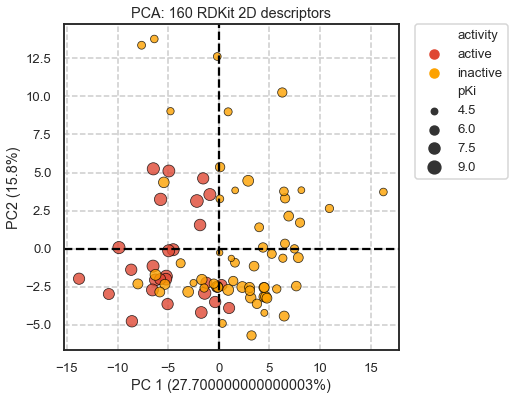

In [312]:
df_pca = df_erk2_mols[['activity', 'pKi']].copy()
df_pca['activity'] = ['active' if i else 'inactive' for i in df_pca.activity]
df_pca['pc1'] = components[0]
df_pca['pc2'] = components[1]

# Plot the PCS
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
sns.scatterplot(x='pc1', y='pc2', hue='activity', size='pKi', data=df_pca, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='PCA: 160 RDKit 2D descriptors',
      xlabel=f'PC 1 ({var_[0]}%)', ylabel=f'PC2 ({var_[1]}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

## Feature Selection

**Selecting molecular descriptors following the Ash & Fourches (2017) procedure** (it is assumed that these steps were made independently for each set of descriptors):
1. **Low variance filter:** Features in the lower variance quartile were discarded.
    - This means that at least 25% of the features will be removed.
    
    
2. **Correlation filters:** For any pair of descriptors with $|r| > 0.9$ the descriptor with largest mean of $|r|$ was removed.

#### Additionally they did the following analysis (not necessarily to drop features):
1. **Pearson correlation between each descriptor and pKi values.**  
2. **Paired t-test between active and inactive ligands using each set of descriptors.**

### Variance Threshold


In [313]:
from sklearn.preprocessing import MinMaxScaler

In [314]:
# first scale the variables using min_max scaler
min_max_scaler = MinMaxScaler()


In [323]:
min_max_scaler = MinMaxScaler()
X_rdk2d_minmax = min_max_scaler.fit_transform(X_rdk2d)
variances = X_rdk2d_minmax.var(axis=0)
# Get the value of the first quartile
q1 = np.quantile(variances, 0.25)
# Variance filter
variance_filter = variances > q1
# Apply the filter
X_rdk2d_var = X_rdk2d.loc[:, variance_filter]

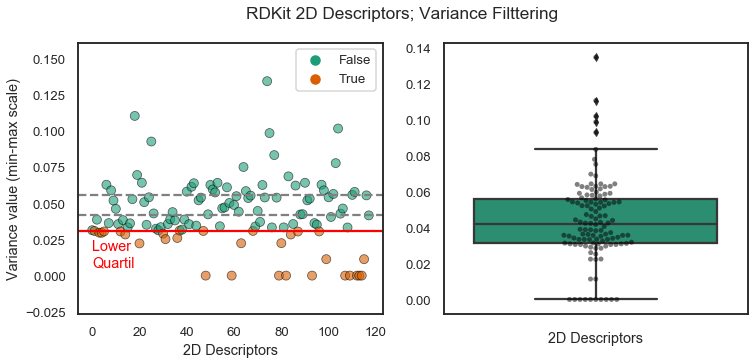

30 features were dropped.


In [324]:
# Plot variances
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
fig.suptitle('RDKit 2D Descriptors; Variance Filttering')
q1, q2, q3 = np.quantile(variances, [0.25, 0.5, 0.75])
n_descriptors = X_rdk2d.shape[1]

ax1 = sns.scatterplot(x=range(0, n_descriptors), 
                      y=variances, ax=ax1, hue=(variances < q1),
                      edgecolor='k', alpha = 0.6)
ax1.set(xlabel='2D Descriptors', ylabel='Variance value (min-max scale)')
ax1.annotate('Lower\nQuartil', xy=(0, q1-.025), color='red')
ax1.axhline(q1, color='red')
ax1.axhline(q2, color='grey', linestyle='--')
ax1.axhline(q3, color='grey', linestyle='--')

ax2 = sns.boxplot(y=variances, ax=ax2)
ax2 = sns.swarmplot(y=variances, ax=ax2, color='black', alpha=0.5)
ax2.set(xlabel='2D Descriptors')
plt.show()

print(sum(variances <= q1), 'features were dropped.')

### Identifying binary features 

In [327]:
# Identify binary columns:
[col for col in X_rdk2d_var.columns if np.isin(X_rdk2d_var[col].unique(), [0, 1]).all() ]


['NumSaturatedRings',
 'NumSaturatedHeterocycles',
 'NumSaturatedCarbocycles',
 'NumAliphaticCarbocycles',
 'MQN15',
 'MQN25',
 'MQN29',
 'MQN33']

 These features have only zeros and ones, however,
 none of them are binary variables, i.e., they could take values different from 0 and 1
 
 In particular: 
 > MQN descriptors are '*Molecular quantitaive numbers*', which were defined by in
 'Classification of Organic Molecules by Molecular Quantum Numbers' by Nguyen, et al. (2009). DOI: 10.0.3.234/cmdc.200900317

## Z-score Standarization

In [328]:
# Standarization
scaler = StandardScaler()
X_rdk2d_std = pd.DataFrame(scaler.fit_transform(X_rdk2d_var), columns=X_rdk2d_var.columns, index=X_rdk2d_var.index)
X_rdk2d_std.shape

(87, 88)

## Correlation filtering (Pearson correlation coefficient)

This time we are going to use the 'caret' package in R, the same package that Ash & Fourches used.

In [329]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [344]:
%%R -i X_rdk2d_std -o cols_to_drop

corr_mtx = cor(X_rdk2d_std, method='pearson')
cols_to_drop = caret::findCorrelation(corr_mtx, cutoff=0.9, exact=TRUE, names=TRUE)
cols_to_drop

 [1] "kappa2"            "NumAtoms"          "Chi0v"            
 [4] "NumRotatableBonds" "SMR"               "Chi1v"            
 [7] "Chi1n"             "MQN20"             "Chi2n"            
[10] "MQN1"              "Chi3n"             "smr_VSA7"         
[13] "NumHBD"            "MQN23"             "MQN17"            
[16] "NumLipinskiHBD"    "MQN15"             "MQN42"            
[19] "slogp_VSA7"       


In [331]:
# Drop the identified features by caret
X_rdk2d_corr = X_rdk2d_std.drop(cols_to_drop, axis=1)
X_rdk2d_corr.shape

(87, 69)

### Visualize correlation before and after removing features

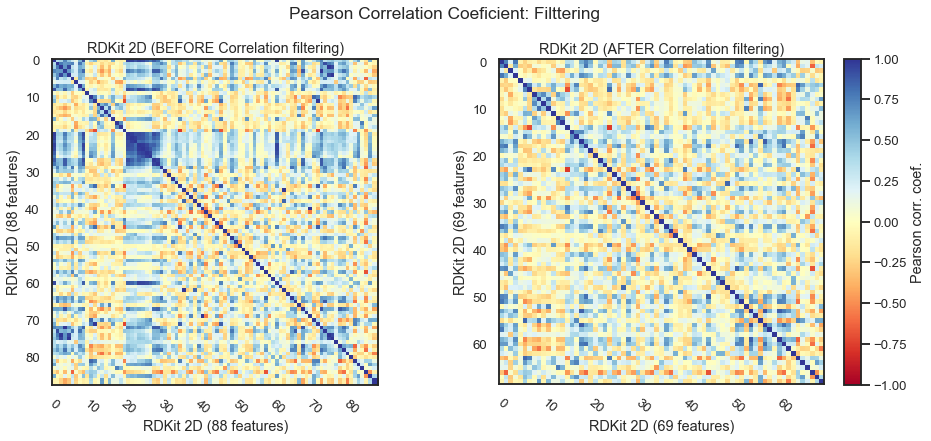

In [332]:
fig = plt.figure(figsize=(16, 6))
plt.suptitle('Pearson Correlation Coeficient: Filttering', y = 1.0)

# ALL FEATURES POST VARIANCE THR
n_init_feat = X_rdk2d_std.shape[1]
corr_mtx_all = X_rdk2d_std.corr(method='pearson')

plt.subplot(1, 2, 1)
plt.imshow(corr_mtx_all, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_init_feat, 10))
plt.xticks(range(0, n_init_feat, 10), rotation=-40)
axlabel_ = f'RDKit 2D ({n_init_feat} features)'
plt.xlabel(axlabel_); plt.ylabel(axlabel_)
plt.title('RDKit 2D (BEFORE Correlation filtering)')


# FEATURES POST CORR FILTERING
n_new_feat = X_rdk2d_corr.shape[1]
corr_mtx_post_corr = X_rdk2d_corr.corr(method='pearson')

plt.subplot(1, 2, 2)
plt.imshow(corr_mtx_post_corr, cmap='RdYlBu', vmin=-1, vmax=1)
plt.yticks(range(0, n_new_feat, 10))
plt.xticks(range(0, n_new_feat, 10), rotation=-40)
axlabel_ = f'RDKit 2D ({n_new_feat} features)'
plt.xlabel(axlabel_); plt.ylabel(axlabel_)
plt.title('RDKit 2D (AFTER Correlation filtering)')

cbar = plt.colorbar()
cbar.set_label('Pearson corr. coef.')
plt.show()

## Pearson Correlation of 68 descriptors with pKi values

In [333]:
from scipy.stats import pearsonr

In [334]:
rdk2d_corr_values_with_pki = [pearsonr(desc, df_erk2_mols.pKi) for i, desc in X_rdk2d_corr.iteritems()]

df_rdk2d_corr_corr_pki = pd.DataFrame({
          'descriptor': X_rdk2d_corr.columns,
          'corr_pearson': [i[0] for i in rdk2d_corr_values_with_pki],
          'p_value': [i[1] for i in rdk2d_corr_values_with_pki],
          'significative': [i[1] < 0.05 for i in rdk2d_corr_values_with_pki]
         })

In [338]:
corr_features_above_04 = df_rdk2d_corr_corr_pki[(df_rdk2d_corr_corr_pki.corr_pearson.abs() >= 0.4) & 
                           (df_rdk2d_corr_corr_pki.significative)]
corr_features_above_04.reset_index()

,index,descriptor,corr_pearson,p_value,significative
0,6,NumAromaticRings,0.416152,6.100383e-05,True
1,15,Chi2v,0.420426,5.027960e-05,True
2,17,kappa3,0.443204,1.715433e-05,True
3,20,slogp_VSA3,-0.426651,3.776312e-05,True
4,22,slogp_VSA5,0.423925,4.283640e-05,True
5,29,smr_VSA3,0.467570,4.970182e-06,True
6,53,MQN13,0.466663,5.213889e-06,True
7,56,MQN19,0.545342,4.713565e-08,True
8,57,MQN22,0.543334,5.397123e-08,True
9,61,MQN28,0.484526,1.981072e-06,True


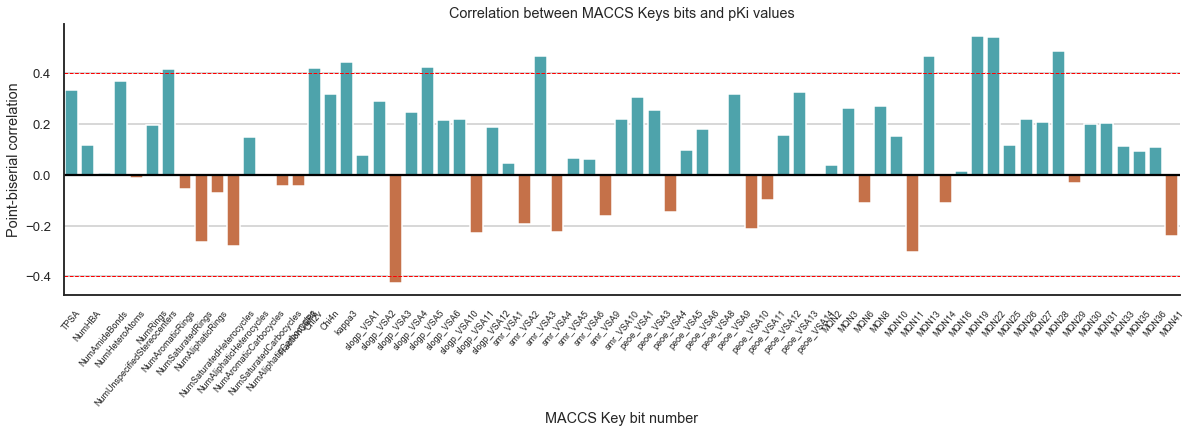

In [336]:
# plot  correlation values
color_palette = ['#3eb0ba' if i > 0 else '#da6a34' for i in df_rdk2d_corr_corr_pki.corr_pearson]
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x='descriptor', y = 'corr_pearson', data=df_rdk2d_corr_corr_pki, palette=color_palette, ax=ax)

ax.set_xticklabels(df_rdk2d_corr_corr_pki.descriptor, rotation=50, fontdict={'fontsize': 9})
ax.set(ylabel='Point-biserial correlation', xlabel='MACCS Key bit number',
       title='Correlation between MACCS Keys bits and pKi values')
plt.grid(axis='y')
plt.axhline(color='k')
plt.axhline(y=0.4, linestyle='--', linewidth=1, color='red')
plt.axhline(y=-0.4, linestyle='--', linewidth=1, color='red')
sns.despine()
plt.show()

In [ ]:
## Clustering 

In [359]:
import scipy.spatial.distance as ssd
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering

In [374]:
dist_euc_std = ssd.pdist(X_rdk2d_std.T, 'euclidean')

link_euc = linkage(ssd.squareform(dist_euc_std), method='average')

ssd.squareform(dist_euc_std)

/home/joel/anaconda3/envs/mds/lib/python3.7/site-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


array([[ 0.        , 10.47656728, 10.02398291, ...,  8.45040333,
        13.63215455, 13.61067515],
       [10.47656728,  0.        ,  6.18802019, ..., 13.27310414,
        13.62413915, 13.50572978],
       [10.02398291,  6.18802019,  0.        , ..., 13.71123913,
        14.77525656, 14.73520404],
       ...,
       [ 8.45040333, 13.27310414, 13.71123913, ...,  0.        ,
        10.36126919, 10.51920184],
       [13.63215455, 13.62413915, 14.77525656, ..., 10.36126919,
         0.        ,  0.74396437],
       [13.61067515, 13.50572978, 14.73520404, ..., 10.51920184,
         0.74396437,  0.        ]])

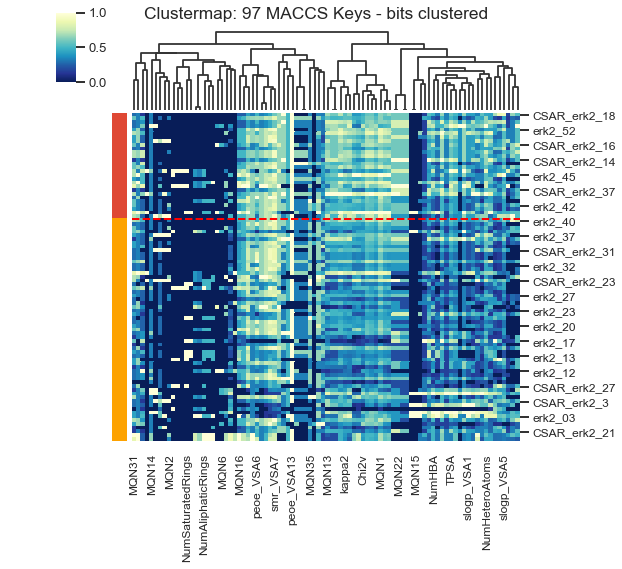

In [382]:
colors_rows = ['#df4834' if i >= 7.5 else '#fda200' for i in df_erk2_mols['pKi']]

clusmap = sns.clustermap(X_rdk2d_std, cmap ='YlGnBu_r',
                standard_scale=1,
                row_cluster=False,
                col_linkage=link_euc,
                #z_score=1,
                row_colors=colors_rows,
                cbar_pos=(0.1, .88, .03, .12),
                tree_kws={'linewidth': 1.8},
                figsize=(9, 8)
              )

# Number of actives
n_actives = sum(df_erk2_mols['pKi'] >= 7.5)
ax = clusmap.ax_heatmap
ax.set_xticklabels(clusmap.ax_heatmap.get_xmajorticklabels(), fontsize = 12)
ax.set_yticklabels(clusmap.ax_heatmap.get_ymajorticklabels(), fontsize = 12)
ax.hlines(y=n_actives, xmin=0, xmax=97, linewidth=2, linestyle='--', color = 'r')
clusmap.fig.suptitle('Clustermap: 97 MACCS Keys - bits clustered', y=1.01) 
plt.show()



### Use PCA to start the EDA: 
#### Just for visualization purposes before preprocessing and feature selection

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca = PCA(n_components=2)
pca_pipe = Pipeline(steps = [('scaler', scaler), ('pca', pca)])

X_rdk2d = df_rdkit_all
pca_pipe.fit(X_rdk2d)
# Components
components = pca_pipe.transform(X_rdk2d).T
# Variance ratio
var_ = pca_pipe['pca'].explained_variance_ratio_.round(3) * 100

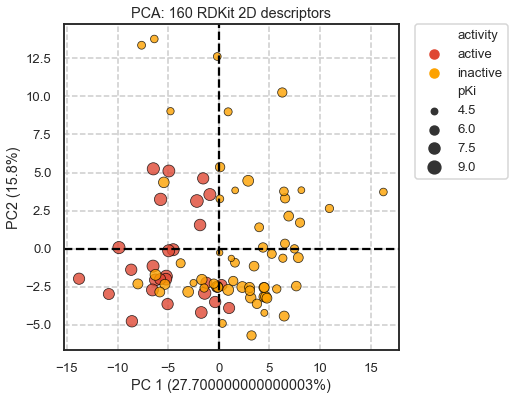

In [71]:
# Create a dataframe to plot the values
df_pca = df_erk2_mols[['activity', 'pKi']].copy()
df_pca['activity'] = ['active' if i else 'inactive' for i in df_pca.activity]
df_pca['pc1'] = components[0]
df_pca['pc2'] = components[1]

# Plot the PCS
fig, ax = plt.subplots(figsize=(6, 6))
ax.axvline(linestyle='--', color='k')
ax.axhline(linestyle='--', color='k')
sns.scatterplot(x='pc1', y='pc2', hue='activity', size='pKi', data=df_pca, 
                ax=ax, palette=['#df4834', '#fda200'], edgecolor='k', alpha=0.8)
ax.set(title='PCA: 160 RDKit 2D descriptors',
      xlabel=f'PC 1 ({var_[0]}%)', ylabel=f'PC2 ({var_[1]}%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(linestyle='--')
plt.show()

### Feature Standarization

In [66]:
scaler = StandardScaler()
X_rdk2d_std = pd.DataFrame(scaler.fit_transform(X_rdk2d), columns=X_rdk2d.columns, index=X_rdk2d.index)
X_rdk2d_std

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,MQN33,MQN34,MQN35,MQN36,MQN37,MQN38,MQN39,MQN40,MQN41,MQN42
CSAR_erk2_18,0.203092,0.274699,0.203092,0.115122,0.149433,-0.311417,-0.452501,-0.306479,0.159179,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
erk2_54,0.677014,0.054409,0.677014,-0.617947,-0.836924,0.803019,0.881874,0.794654,0.441804,0.0,...,-0.188982,0.0,0.729612,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_20,0.214731,0.185849,0.214731,-1.109691,-0.727324,0.542718,0.452097,0.541695,0.724428,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_17,0.174036,-2.177998,0.174036,-0.831444,-0.890542,0.898298,0.909916,0.897070,0.724428,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
erk2_52,0.258939,0.266320,0.258939,0.184461,-0.875574,0.502081,0.392179,0.508486,0.912845,0.0,...,-0.188982,0.0,-0.680972,0.923548,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CSAR_erk2_38,-0.539637,-0.147341,-0.539637,4.565558,-0.361741,1.243971,1.357450,1.251962,-0.688694,0.0,...,-0.188982,0.0,-0.680972,0.923548,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_1,-0.269155,0.448078,-0.269155,-0.880763,2.006031,-1.719070,-1.754613,-1.716937,-1.442359,0.0,...,-0.188982,0.0,0.729612,-1.847096,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
CSAR_erk2_21,0.136223,0.444504,0.136223,-1.102541,0.450219,-1.023947,-1.086011,-1.020370,-0.688694,0.0,...,-0.188982,0.0,-0.680972,-0.461774,0.0,0.0,0.0,-0.107833,-0.517178,-0.506824
erk2_02,1.205118,0.214082,1.205118,-1.222872,0.233150,0.177860,0.250473,0.184051,0.347596,0.0,...,-0.188982,0.0,-0.680972,2.308870,0.0,0.0,0.0,-0.107833,2.878631,2.759378


In [229]:
from correlation_filter import *
# Compute the correlation matrix
df_full_corr = X_rdk2d_std.corr(method='pearson')
# Drop high correlated features
features_to_drop_rdk2d = features_to_drop(dataset=X_rdk2d_std, correlated_mtx = df_full_corr, 
                         max_thr = 1, min_thr = 0.9, step =  0.01, verbose = False, absoluted=True)